## Standardize predicted data in output and increased regularization

In [1]:
# %pip install --upgrade git+https://github.com/Rayhane-mamah/hparams
# %pip install tensorboad
# %pip install wordcloud

In [2]:
# %pip install scikit-learn --upgrade

## Explore use of dataloader

[x] Select Subject

[x] Load fMRI betas and image data

[x] Apply ROI on fMRI, eventually flatten

[x] Load fMRI betas, image and captions


[x] Apply transforms to images (?)

[x] Apply tokenizer



## VDVAE Import

In [3]:
# nltk.download('stopwords')

In [2]:
import pickle

from hparams import HParams
from hps import Hyperparams
from vae import VAE

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.manifold import TSNE
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
# from wordcloud import WordCloud

In [3]:
import numpy as np
import os
import glob
from os.path import join as opj
import h5py  
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
from scipy.io import loadmat
import torch
from torch.utils.data import Dataset, Subset, DataLoader
import json
import clip
from PIL import Image
# from diffusers import VersatileDiffusionPipeline
# from diffusers import VersatileDiffusionDualGuidedPipeline
from diffusers.models import AutoencoderKL, DualTransformer2DModel, Transformer2DModel, UNet2DConditionModel
from versatile_diffusion_dual_guided import VersatileDiffusionDualGuidedPipeline
from versatile_diffusion_dual_guided_fake_images import VersatileDiffusionDualGuidedFromCLIPEmbeddingPipeline
from autoencoder import *
from torchsummary import summary
import torchvision
import tqdm
from sklearn.linear_model import Ridge
import pickle
import wandb
from diffusers.utils import (
    PIL_INTERPOLATION,
    deprecate,
    is_accelerate_available,
    is_accelerate_version,
    logging,
    randn_tensor,
    replace_example_docstring,
)

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# from yellowbrick.cluster import KElbowVisualizer

/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [4]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matteoferrante. Use `wandb login --relogin` to force relogin


True

In [99]:
train=False
compute_dataset=False
decode_all_test_set=True

In [6]:
base_path="/home/matteo/data/NSD"
timeseries_path=opj(base_path,"nsddata_timeseries")
betas_path=opj(base_path,"nsddata_betas")

stimuli_path=opj(base_path,"nsddata_stimuli","stimuli","nsd")
stim_file_path=opj(stimuli_path,"nsd_stimuli.hdf5")
sub="subj01"
mod="func1pt8mm"
subj_data_path=opj(timeseries_path,"ppdata",sub,mod,"timeseries")
subj_betas_path=opj(betas_path,"ppdata",sub,mod,"betas_assumehrf")

subj_betas_roi_extracted_path=opj(base_path,"processed_roi",sub,mod)

stim_order_path=opj(base_path,"nsddata","experiments","nsd","nsd_expdesign.mat")
stim_info_path=opj(base_path,"nsddata","experiments","nsd","nsd_stim_info_merged.csv")
stim_captions_train_path=opj(base_path,"nsddata_stimuli","stimuli","nsd","annotations",f"captions_train2017.json")
stim_captions_val_path=opj(base_path,"nsddata_stimuli","stimuli","nsd","annotations",f"captions_val2017.json")

processed_data=opj(base_path,"processed_roi",sub)

In [7]:
processed_data

'/home/matteo/data/NSD/processed_roi/subj01'

In [8]:
sub_idx=int(sub.split("0")[-1])

In [9]:
sub_idx

1

In [10]:
fmri_train_data=opj(processed_data,f"MNI/nsd_train_fmriavg_nsdgeneral_sub{sub_idx}.npy")
imgs_train_data=opj(processed_data,f"MNI/nsd_train_stim_sub{sub_idx}.npy")
captions_train_data=opj(processed_data, f"MNI/nsd_train_cap_sub{sub_idx}.npy")
       
fmri_test_data=opj(processed_data,f"MNI/nsd_test_fmriavg_nsdgeneral_sub{sub_idx}.npy")
imgs_test_data=opj(processed_data,f"MNI/nsd_test_stim_sub{sub_idx}.npy")
captions_test_data=opj(processed_data, f"MNI/nsd_test_cap_sub{sub_idx}.npy")


target_sub_idx=2


## extra data
imgs_comparison_data=f"/home/matteo/data/NSD/processed_roi/subj0{target_sub_idx}/aligned/nsd_comparison_stim_sub{target_sub_idx}.npy"
fmri_aligned_data=opj(f"/home/matteo/data/NSD/processed_roi/subj0{target_sub_idx}",f"aligned/nsd_comparison_fmriavg_nsdgeneral_sub{target_sub_idx}.npy") 
fmri_notaligned_data=opj(f"/home/matteo/data/NSD/processed_roi/subj0{target_sub_idx}",f"aligned/nsd_comparison_NOTALIGNED_fmriavg_nsdgeneral_sub{target_sub_idx}.npy")  


In [74]:
def get_aligned_dataset(target_sub_idx,method="ridge",split="comparison",fraction=10):
    
    ## LAVORARE QUI
    
    assert method in ["ridge","hyper","randomhyper", "anat"], 'method should be in ["ridge","hyper","randomhyper", "anat"]'
    assert split in ["comparison","test","train"], 'split should be in ["comparison","test","train"]'
    assert fraction in [10,25,50,100], 'fraction should be 10,25, 50 or 100'
    
    
    # load stimuli
    if split=="comparison":
        imgs_data=f"/home/matteo/data/NSD/processed_roi/subj0{target_sub_idx}/aligned/nsd_comparison_stim_sub{target_sub_idx}.npy"
    elif split=="test": 
        imgs_data=f"/home/matteo/data/NSD/processed_roi/subj0{target_sub_idx}/aligned/nsd_test_stim_sub{target_sub_idx}.npy"
    elif split=="train":
        imgs_data=opj(base_path,"processed_roi",f"subj0{target_sub_idx}",f"MNI/nsd_train_stim_sub{target_sub_idx}.npy")

    # load aligned data
    
    if method=="anat":
        if split=="train":
            data=opj(base_path,"processed_roi",f"subj0{target_sub_idx}",f"MNI/nsd_train_fmriavg_nsdgeneral_sub{sub_idx}.npy")
        else:
            data=opj(f"/home/matteo/data/NSD/processed_roi/subj0{target_sub_idx}",f"aligned/nsd_{split}_NOTALIGNED_fmriavg_nsdgeneral_sub{target_sub_idx}.npy") 
    else:
    
        data=opj(f"/home/matteo/data/NSD/processed_roi/subj0{target_sub_idx}",f"aligned/nsd_{split}_fmriavg_nsdgeneral_sub{target_sub_idx}_{method}_fraction-{fraction}.npy")
    
    return data,imgs_data

In [75]:
data,img_data=get_aligned_dataset(target_sub_idx,"anat",split="test",fraction=100)

(952, 14197)

In [63]:
config={"sub":sub, "mod": mod, "model": "Ridge"}
wandb.init(project="BrainDecodingNSD_MNI", config=config)

In [64]:
class NSDDataset(Dataset):
    

    
    def __init__(self, fmri_data,imgs_data,caption_data,transforms=None):
        self.fmri_data=np.load(fmri_data)
        self.imgs_data=np.load(imgs_data).astype(np.uint8)
        self.caption_data=np.load(caption_data,allow_pickle=True)
        self.transforms=transforms
        
    def __len__(self):
        return  len(self.fmri_data)
    
    def __getitem__(self,idx):
        fmri=torch.tensor(self.fmri_data[idx])
        img=Image.fromarray(self.imgs_data[idx])
        
        if self.transforms:
            img=self.transforms(img)
        
        caption=self.caption_data[idx][0] #cambiare se ne voglio altre
        
        return fmri,img,caption

## Prepare Dataset

In [65]:
BS=4

In [66]:
tr=torchvision.transforms.ToTensor()
train_dataset=NSDDataset(fmri_train_data,imgs_train_data,captions_train_data,transforms=tr)
test_dataset=NSDDataset(fmri_test_data,imgs_test_data,captions_test_data,transforms=tr)

In [78]:
# aligned_comparison_dataset=NSDDataset(fmri_aligned_data,imgs_comparison_data,captions_test_data,transforms=tr)
# notaligned_comparison_dataset=NSDDataset(fmri_notaligned_data,imgs_comparison_data,captions_test_data,transforms=tr)


In [16]:
# train_dataset=Subset(dataset,train_indices)
# # val_dataset=Subset(dataset,val_indices)
# test_dataset=Subset(dataset,test_indices)


In [17]:
# x,y,c  = next(iter(train_dataloader))



In [80]:
train_dataloader=DataLoader(train_dataset,BS,shuffle=True)
# val_dataloader=DataLoader(val_dataset,BS,shuffle=True)
test_dataloader=DataLoader(test_dataset,BS,shuffle=False)
# align_comparison_dataloader=DataLoader(aligned_comparison_dataset,BS,shuffle=False)
# notalign_comparison_dataloader=DataLoader(notaligned_comparison_dataset,BS,shuffle=False)


In [81]:
x,y,c  = next(iter(train_dataloader))
x,y,c  = next(iter(train_dataset))

In [82]:
to_pil=torchvision.transforms.ToPILImage()

In [83]:
y=to_pil(y)

Text(0.5, 1.0, 'A man standing near the ocean with surf boards')

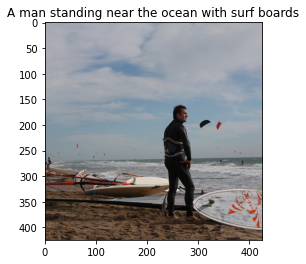

In [84]:
plt.imshow(y)
plt.title(c)

## Load CLIP model

Just a check that everything works

In [85]:
device="cuda:2"
# model, preprocess = clip.load("ViT-L/14", device=device)


# # # device = "cuda" if torch.cuda.is_available() else "cpu"
# # device="cpu"
# # model, preprocess = clip.load("ViT-B/32", device=device)

## Use Versatile diffusion with dual guidance

1) To stay close to original implementation, we used null images and text prompt and then replace them into the call function of pipeline with predicted from CLIP (and finally from brain).

2) Keep in mind that output of CLIPTextEncoder is [null_prompt, text_prompt] and same for images to avoid double forward pass when using classifier guidance

### Extra for CLIP guidance

In [86]:

pipe_embed = VersatileDiffusionDualGuidedFromCLIPEmbeddingPipeline.from_pretrained("shi-labs/versatile-diffusion", )

pipe_embed.remove_unused_weights()

pipe_embed = pipe_embed.to(device)

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

In [87]:
guidance_scale = 7.5
num_images_per_prompt =1
do_classifier_free_guidance = False

In [88]:
null_prompt=""
null_img=Image.fromarray(np.zeros((425,425,3),dtype=np.uint8))

## Load pretrained VDVAE

In [89]:
with open('/home/matteo/models/vdvae/H.sav', 'rb') as fp:
    d = pickle.load(fp)

In [90]:
H=Hyperparams()
for k,v in d.items():
    H[k]=v

In [91]:
vae=VAE(H)

In [92]:
state_dict = torch.load("/home/matteo/models/vdvae/vae2.pt")
new_state_dict = {}
l = len('module.')
for k in state_dict:
    if k.startswith('module.'):
        new_state_dict[k[l:]] = state_dict[k]
    else:
        new_state_dict[k] = state_dict[k]
state_dict = new_state_dict
vae.load_state_dict(state_dict)

<All keys matched successfully>

In [93]:
vae=vae.to(device)

In [94]:
x,y,c=next(iter(train_dataset))

In [95]:
# transform=torchvision.transforms.Compose([to_pil,torchvision.transforms.Resize(64),torchvision.transforms.ToTensor()])
transform=torchvision.transforms.Compose([to_pil,torchvision.transforms.Resize(64),torchvision.transforms.ToTensor(),torchvision.transforms.Normalize(mean=110/255,std=69/255)])

In [36]:
# variate_masks = [None] * (sum(hparams.model.down_n_blocks_per_res) + len(hparams.model.down_strides))


In [96]:
unnorm=torchvision.transforms.Lambda(lambda x: 69/255*x+110/255)

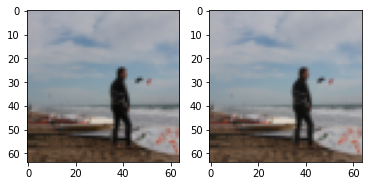

In [97]:
with torch.no_grad():
    img_in =transform(y).unsqueeze(0).to(device)
    activations = vae.encoder.forward(img_in)
    px_z, stats = vae.decoder.forward(activations, get_latents=True)
    
    img_out=vae.decoder.out_net.sample(px_z)
    
    # z=autoencoder.bottom_up(img_in.cuda())
    # outputs, posterior_dist_list, prior_kl_dist_list=autoencoder.top_down(z,variate_masks)
    # img_out=autoencoder.top_down.sample(outputs).cpu()

latents=[i["z"] for i in stats[:31]]

fig,axs=plt.subplots(1,2,figsize=(6,3))
axs[0].imshow(unnorm(img_in[0]).permute(1,2,0).cpu())
axs[1].imshow(img_out[0])


## Build brain model to predict CLIP image and text features
Collect all clip image and txt represenations for the entire dataset.

In [98]:
keep=31


In [100]:
if compute_dataset:
    train_fmri=[]
    train_imgs=[]
    train_captions=[]
    train_z={}
    train_clip_img_embeds=[]
    train_clip_txt_embeds=[]
    train_clip_pool_txt=[]

    first=True

    for x,y,c in tqdm.tqdm(train_dataloader):

        #save fMRI data
        train_fmri.append(x)

        #save img data
        train_imgs.append(y)

        train_captions+=list(c)

        #encode images in autoencoder and save z representation
        with torch.no_grad():
            T=torch.stack([transform(i) for i in y])
            act=vae.encoder.forward(T.to(device))
            px_z, stats = vae.decoder.forward(act, get_latents=True)

            latents=[i["z"] for i in stats[:keep]]

            if first:
                z={k:v.cpu().clamp(-10,10) for k,v in zip(np.arange(keep),latents)}
                train_z.update(z)
                first=False
            else:
                z={k:v.cpu().clamp(-10,10) for k,v in zip(np.arange(keep),latents)}

                for k in train_z.keys():
                    train_z[k]=torch.cat([train_z[k],z[k]],axis=0)





            #encode images in CLIP
            image_features=pipe_embed._encode_image_prompt([to_pil(i) for i in y],device=device,num_images_per_prompt=num_images_per_prompt,do_classifier_free_guidance=do_classifier_free_guidance).cpu()
            train_clip_img_embeds.append(image_features)

            #encode text in clip
            text_features=pipe_embed._encode_text_prompt(c,device=device,num_images_per_prompt=num_images_per_prompt,do_classifier_free_guidance=do_classifier_free_guidance).cpu()
            train_clip_txt_embeds.append(text_features)

            #txt pool
            # text = clip.tokenize(c).to(device  )
            # text_pool_features = model.encode_text(text).cpu()
            # train_clip_pool_txt.append(text_pool_features)

    train_clip_txt_embeds = torch.cat(train_clip_txt_embeds,axis=0)
    train_clip_img_embeds = torch.cat(train_clip_img_embeds,axis=0)

    train_fmri = torch.cat(train_fmri,axis=0)
    # train_z = torch.cat(train_z,axis=0)  
    # train_z={k:torch.cat(v,axis=0) for k,v in train_z.items()}
    train_imgs = torch.cat(train_imgs,axis=0)
    # train_clip_pool_txt = torch.cat(train_clip_pool_txt,axis=0)

In [101]:
if compute_dataset:
    test_fmri=[]
    test_imgs=[]
    test_captions=[]

    test_z={}
    test_clip_img_embeds=[]
    test_clip_txt_embeds=[]
    test_clip_pool_txt=[]

    first=True
    for x,y,c in tqdm.tqdm(test_dataloader):

        #save fMRI data
        test_fmri.append(x)

        #save img data
        test_imgs.append(y)

        test_captions+=list(c)

        #encode images in autoencoder and save z representation
        with torch.no_grad():
            T=torch.stack([transform(i) for i in y])
            act=vae.encoder.forward(T.to(device))
            px_z, stats = vae.decoder.forward(act, get_latents=True)

            latents=[i["z"] for i in stats[:keep]]
            if first:
                z={k:v.cpu().clamp(-10,10) for k,v in zip(np.arange(keep),latents)}

                test_z.update(z)
                first=False
            else:
                z={k:v.cpu().clamp(-10,10) for k,v in zip(np.arange(keep),latents)}

                for k in train_z.keys():
                    test_z[k]=torch.cat([test_z[k],z[k]],axis=0)
            #encode images in CLIP
            image_features=pipe_embed._encode_image_prompt([to_pil(i) for i in y],device=device,num_images_per_prompt=num_images_per_prompt,do_classifier_free_guidance=do_classifier_free_guidance).cpu()
            test_clip_img_embeds.append(image_features)

            #encode text in clip
            text_features=pipe_embed._encode_text_prompt(c,device=device,num_images_per_prompt=num_images_per_prompt,do_classifier_free_guidance=do_classifier_free_guidance).cpu()
            test_clip_txt_embeds.append(text_features)

            # #txt pool
            # text = clip.tokenize(c).to(device)
            # test_pool_features = model.encode_text(text).cpu()
            # test_clip_pool_txt.append(test_pool_features)


    test_clip_txt_embeds = torch.cat(test_clip_txt_embeds,axis=0)
    test_clip_img_embeds = torch.cat(test_clip_img_embeds,axis=0)
    # test_clip_pool_txt = torch.cat(test_clip_pool_txt,axis=0)

    test_fmri = torch.cat(test_fmri,axis=0)
    # test_z = torch.cat(test_z,axis=0)
    # test_z={k:torch.cat(v,axis=0) for k,v in test_z.items()}

    test_imgs = torch.cat(test_imgs,axis=0)

In [102]:
if compute_dataset:
    os.makedirs(f"models/{sub}",exist_ok=True)
    
    ## train
    torch.save(train_fmri,f"models/{sub}/train_fmri.pt")
    torch.save(train_clip_txt_embeds,f"models/{sub}/train_clip_txt_embeds.pt")
    torch.save(train_clip_img_embeds,f"models/{sub}/train_clip_img_embeds.pt")
    torch.save(train_imgs,f"models/{sub}/train_imgs.pt")
    with open(f"models/{sub}/train_z.sav","wb") as f:
        pickle.dump(train_z,f)
        
    with open(f"models/{sub}/train_captions.sav","wb") as f:
        pickle.dump(train_captions,f)
        
    print("saved training stuff")
    
    ## test
    torch.save(test_fmri,f"models/{sub}/test_fmri.pt")
    torch.save(test_clip_txt_embeds,f"models/{sub}/test_clip_txt_embeds.pt")
    torch.save(test_clip_img_embeds,f"models/{sub}/test_clip_img_embeds.pt")
    torch.save(test_imgs,f"models/{sub}/test_imgs.pt")
    with open(f"models/{sub}/test_z.sav","wb") as f:
        pickle.dump(test_z,f)
        
    with open(f"models/{sub}/test_captions.sav","wb") as f:
        pickle.dump(test_captions,f)
    
    
    print("saved testing stuff")
    
else:
    ## train
    train_fmri=torch.load(f"models/{sub}/train_fmri.pt")
    train_clip_txt_embeds=torch.load(f"models/{sub}/train_clip_txt_embeds.pt")
    train_clip_img_embeds= torch.load(f"models/{sub}/train_clip_img_embeds.pt")
    train_imgs=torch.load(f"models/{sub}/train_imgs.pt")
    with open(f"models/{sub}/train_z.sav","rb") as f:
        train_z=pickle.load(f)
        
    with open(f"models/{sub}/train_captions.sav","rb") as f:
        train_captions=pickle.load(f)
    
#     ## val
#     val_fmri=torch.load(f"models/{sub}/val_fmri.pt")
#     val_clip_txt_embeds=torch.load(f"models/{sub}/val_clip_txt_embeds.pt")
#     val_clip_img_embeds= torch.load(f"models/{sub}/val_clip_img_embeds.pt")
#     val_imgs=torch.load(f"models/{sub}/val_imgs.pt")
#     with open(f"models/{sub}/val_z.sav","rb") as f:
#         val_z=pickle.load(f)
        
#     with open(f"models/{sub}/val_captions.sav","rb") as f:
#         val_captions=pickle.load(f)
    ## test
    test_fmri=torch.load(f"models/{sub}/test_fmri.pt")
    test_clip_txt_embeds=torch.load(f"models/{sub}/test_clip_txt_embeds.pt")
    test_clip_img_embeds= torch.load(f"models/{sub}/test_clip_img_embeds.pt")
    test_imgs=torch.load(f"models/{sub}/test_imgs.pt")
    with open(f"models/{sub}/test_z.sav","rb") as f:
        test_z=pickle.load(f)
    with open(f"models/{sub}/test_captions.sav","rb") as f:
        test_captions=pickle.load(f)
    

In [103]:
train_fmri_mean=torch.mean(train_fmri,axis=0)
train_fmri_std=torch.std(train_fmri,axis=0)

train_fmri_norm=(train_fmri-train_fmri_mean)/train_fmri_std
# val_fmri_norm=(val_fmri-train_fmri_mean)/train_fmri_std
test_fmri_norm=(test_fmri-train_fmri_mean)/train_fmri_std


train_fmri_norm=torch.nan_to_num(train_fmri_norm)

test_fmri_norm=torch.nan_to_num(test_fmri_norm)

In [104]:
# fix nan

for k in train_z.keys():
    train_z[k]=torch.nan_to_num(train_z[k])
    # val_z[k]=torch.nan_to_num(val_z[k])
    test_z[k]=torch.nan_to_num(test_z[k])
    

## Brain Models : Ridge Regression for Everything



[ ] ALLENARE BRAIN TO LATENT

[ ] FARE IL DECODING 


In [105]:

if train:
    brain_to_latent ={}
    keys=train_z.keys()
    alphas=[5e4]*len(keys)
    for k,alpha in tqdm.tqdm(list(zip(keys,alphas))):
        brain_vdvae_latent=Ridge(alpha, max_iter=10000, fit_intercept=True)
        brain_vdvae_latent.fit(train_fmri_norm.numpy(),train_z[k].reshape(train_z[k].shape[0],-1).numpy())
        brain_to_latent[k]=brain_vdvae_latent

In [106]:
if train:
    os.makedirs(f"models/{sub}/decoding",exist_ok=True)
    for i in keys:
        filename = f'brain_to_vdvae_latent_ridge_{i}.sav'
        with open(opj(f"models/{sub}/decoding",filename), 'wb') as f:
            pickle.dump(brain_to_latent[i],f)

In [107]:
max_len_img=257
max_len_txt=77

if train:
    brain_to_img_emb=[]

    for i in tqdm.tqdm(range(max_len_img)):
        m=Ridge(alpha=6e4)
        m.fit(train_fmri_norm.numpy(),train_clip_img_embeds[:,i,:].numpy())
        brain_to_img_emb.append(m)

In [108]:
if train:
    brain_to_txt_emb=[]
    for i in tqdm.tqdm(range(max_len_txt)):
        m=Ridge(alpha=1e5)
        m.fit(train_fmri_norm.numpy(),train_clip_txt_embeds[:,i,:].numpy())
        brain_to_txt_emb.append(m)

In [109]:
if train:
    

    # filename = 'brain_to_latent_ridge.sav'
    # pickle.dump(brain_to_latent, open(opj(f"models/{sub}/decoding",filename), 'wb'))

    for i in range(max_len_img):
        filename = f'brain_to_img_emb_ridge_{i}.sav'
        with open(opj(f"models/{sub}/decoding",filename), 'wb') as f:
            pickle.dump(brain_to_img_emb[i], f)

    for i in range(max_len_txt):
        filename = f'brain_to_txt_emb_ridge_{i}.sav'
        with open(opj(f"models/{sub}/decoding",filename), 'wb') as f:
            pickle.dump(brain_to_txt_emb[i], f)



In [110]:
if train:
    for i in keys:
        filename = f'brain_to_vdvae_latent_ridge_{i}.sav'
        with open(opj(f"models/{sub}/decoding",filename), 'wb') as f:
            pickle.dump(brain_to_latent[i], f)

In [111]:
if not train:
    keys=np.arange(keep)
    # filename='brain_to_latent_ridge.sav'
    brain_to_latent = {}
#     pickle.load(open(opj(f"models/{sub}/decoding",filename), 'rb'))
    
    
    brain_to_img_emb=[]
    brain_to_txt_emb=[]
    
    for k in keys:
        filename = f'brain_to_vdvae_latent_ridge_{k}.sav'
        p=pickle.load(open(opj(f"models/{sub}/decoding",filename), 'rb'))
        brain_to_latent[k]=p

    
    for i in range(max_len_img):
        filename = f'brain_to_img_emb_ridge_{i}.sav'
        p=pickle.load(open(opj(f"models/{sub}/decoding",filename), 'rb'))
        brain_to_img_emb.append(p)
    for i in range(max_len_txt):
        filename = f'brain_to_txt_emb_ridge_{i}.sav'
        p=pickle.load(open(opj(f"models/{sub}/decoding",filename), 'rb'))
        brain_to_txt_emb.append(p)
    

In [112]:
def latent_transformation(latents, shapes):
    layer_dims = np.array([2**4,2**4,2**8,2**8,2**8,2**8,2**10,2**10,2**10,2**10,2**10,2**10,2**10,2**10,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**14])
    transformed_latents = []
    for i in range(31):
        t_lat = latents[:,layer_dims[:i].sum():layer_dims[:i+1].sum()]
        #std_norm_test_latent = (t_lat - np.mean(t_lat,axis=0)) / np.std(t_lat,axis=0)
        #renorm_test_latent = std_norm_test_latent * np.std(kamitani_latents[i][num_test:].reshape(num_train,-1),axis=0) + np.mean(kamitani_latents[i][num_test:].reshape(num_train,-1),axis=0)
        c,h,w=shapes[i]
        transformed_latents.append(t_lat.reshape(len(latents),c,h,w))
    return transformed_latents

## Compute Adjust

In [113]:
adjust=True

In [114]:
filename = f'latent_adjust_values.sav'

if train:
    latent_adjust_values={}
    for i in range(keep):
        latent_adjust_values[i]={"mean":train_z[i].mean(0), "std": train_z[i].std(0)}
        with open(opj(f"models/{sub}",filename), 'wb') as f:
            pickle.dump(latent_adjust_values, f)
else:
        
        with open(opj(f"models/{sub}",filename), 'rb') as f:
            latent_adjust_values=pickle.load( f)

In [115]:
if train:
    clip_img_embeds_mean=train_clip_img_embeds.mean(0)
    clip_img_embeds_std=train_clip_img_embeds.std(0)
   

    clip_txt_embeds_mean=train_clip_txt_embeds.mean(0)
    clip_txt_embeds_std=train_clip_txt_embeds.std(0)
    
    torch.save(clip_img_embeds_mean, opj(f"models/{sub}","clip_img_embeds_mean.pt"))
    torch.save(clip_img_embeds_std, opj(f"models/{sub}","clip_img_embeds_std.pt"))
    torch.save(clip_txt_embeds_mean, opj(f"models/{sub}","clip_txt_embeds_mean.pt"))
    torch.save(clip_txt_embeds_std, opj(f"models/{sub}","clip_txt_embeds_std.pt"))
    
else:
    clip_img_embeds_mean=torch.load(opj(f"models/{sub}","clip_img_embeds_mean.pt"))
    clip_img_embeds_std=torch.load(opj(f"models/{sub}","clip_img_embeds_std.pt"))
   

    clip_txt_embeds_mean=torch.load(opj(f"models/{sub}","clip_txt_embeds_mean.pt"))
    clip_txt_embeds_std=torch.load(opj(f"models/{sub}","clip_txt_embeds_std.pt"))
    

In [116]:

shapes={k: (v.shape[1],v.shape[2],v.shape[3]) for k,v in train_z.items()}

In [117]:
def get_latents(data,brain_to_latent,shapes,adjust=None):
    latents={}
    bs=data.shape[0]
    for k,v in brain_to_latent.items():
        s=shapes[k]
        z=torch.tensor(v.predict(data)).reshape(-1,*s)
        
    
        if adjust is not None and bs>1:
            #compute actual mean and std
            z_mean=z.mean(0)  
            z_std=z.std(0)
            #standardize 
            z = (z - z_mean)/(1e-9+z_std)
            
            #replace with latent mean and std
            z = z*adjust[k]["std"]+adjust[k]["mean"]
        
        latents[k]=z
        
    return latents

In [118]:
def decode_with_partial_sampling(decoder,latents,keep=31):
    xs = {a.shape[2]: a for a in decoder.bias_xs}
    
    out=vae.decoder.forward_manual_latents(keep,latents.values(),t=None)
    
    xs=decoder.out_net.sample(out)
    xs=torch.tensor(xs).permute(0,3,1,2)/255
    return xs

In [119]:
upsample=torchvision.transforms.Resize(512,interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
res=torchvision.transforms.Resize(512)

### Check on aligned data!

- [ ] Predict the whole train set for subject of training and compute the predicted values of z, img_emb and txt_emb
- [ ] Predict the comparison set and adjust values
- [ ] Check reconstructions

In [120]:
if adjust:
    z=get_latents(train_fmri_norm.numpy(),brain_to_latent,shapes,adjust=latent_adjust_values)
else:
    z=get_latents(train_fmri_norm.numpy(),brain_to_latent,shapes)
img_emb=[]
txt_emb=[]

img_pred_emb_mean=[]
img_pred_emb_std=[]

txt_pred_emb_mean=[]
txt_pred_emb_std=[]


for i in tqdm.tqdm(range(max_len_img)):
    emb=torch.tensor(brain_to_img_emb[i].predict(train_fmri_norm.numpy()))
    # print(emb.shape)
    if adjust and len(x)>1:
        #compute actual mean and std
        emb_mean=emb.mean(0)
        emb_std=emb.std(0)
        
        emb= (emb-emb_mean)/emb_std
        emb = emb*clip_img_embeds_std[i]+clip_img_embeds_mean[i]
        
    img_emb.append(emb)
    img_pred_emb_mean.append(emb_mean)
    img_pred_emb_std.append(emb_std)
    
for i in tqdm.tqdm(range(max_len_txt)):


    emb=torch.tensor(brain_to_txt_emb[i].predict(train_fmri_norm.numpy()))
    
    if adjust and len(x)>1:
        #compute actual mean and std
        emb_mean=emb.mean(0)
        emb_std=emb.std(0)
        
        emb= (emb-emb_mean)/emb_std
        
        emb = emb*clip_txt_embeds_std[i]+clip_txt_embeds_mean[i]
    txt_emb.append(emb)
    
    txt_pred_emb_mean.append(emb_mean)
    txt_pred_emb_std.append(emb_std)
    
img_emb=torch.stack(img_emb,1)
txt_emb=torch.stack(txt_emb,1)


100%|██████████████████████████████████████████| 77/77 [00:22<00:00,  3.45it/s]


In [121]:
img_pred_emb_mean=torch.stack(img_pred_emb_mean,0)
img_pred_emb_std=torch.stack(img_pred_emb_std,0)
txt_pred_emb_mean=torch.stack(txt_pred_emb_mean,0)
txt_pred_emb_std=torch.stack(txt_pred_emb_std,0)

# Predict new samples for aligned subjects

In [250]:
# x,y,c  = next(iter(align_comparison_dataloader))
# x,y,c  = next(iter(notalign_comparison_dataloader))

## get data and sample a batch
method="ridge"
fraction=25
data,img_data=get_aligned_dataset(target_sub_idx,method,split="comparison",fraction=fraction)

other_dataset=NSDDataset(data,img_data,captions_test_data,transforms=tr)
other_dataloader=DataLoader(other_dataset,batch_size=BS)


for i,(x,y,c) in enumerate(other_dataloader):
    if i==1:
        break
# x,y,c  = next(iter(other_dataloader))


In [180]:
x.mean(), x.std()

(tensor(386.7736, dtype=torch.float64), tensor(631.1387, dtype=torch.float64))

In [251]:
#just for this example
adjust=True
# x_mean=x.mean(0)
# x_std=x.std(0)
# x_norm = (x-x_mean)/(1e-8+x_std)


x_norm=torch.nan_to_num((x-train_fmri_mean)/(train_fmri_std))

# x_norm = train_fmri_std*x_norm+train_fmri_mean
if adjust:
    z=get_latents(x_norm.numpy(),brain_to_latent,shapes,adjust=latent_adjust_values)
else:
    z=get_latents(x_norm.numpy(),brain_to_latent,shapes)

img_emb=[]
txt_emb=[]
for i in tqdm.tqdm(range(max_len_img)):
    emb=torch.tensor(brain_to_img_emb[i].predict(x_norm.numpy()))
    # print(emb.shape)
    if adjust and len(x)>1:
        #compute actual mean and std

        emb= (emb-img_pred_emb_mean[i])/img_pred_emb_std[i]
        emb = emb*clip_img_embeds_std[i]+clip_img_embeds_mean[i]
    
    img_emb.append(emb)
    
for i in tqdm.tqdm(range(max_len_txt)):


    emb=torch.tensor(brain_to_txt_emb[i].predict(x_norm.numpy()))
    
    if adjust and len(x)>1:
        #compute actual mean and std
        emb= (emb-txt_pred_emb_mean[i])/txt_pred_emb_std[i]

        emb = emb*clip_txt_embeds_std[i]+clip_txt_embeds_mean[i]
    txt_emb.append(emb)
    
img_emb=torch.stack(img_emb,1)
txt_emb=torch.stack(txt_emb,1)

with torch.no_grad():

    
    # guess_img=upsample(autoencoder.decoder.double()(z.to(device)).cpu())
    guess_img=decode_with_partial_sampling(vae.decoder,{k:v.to(device).float() for k,v in z.items()},keep=len(x))
    # img_out=pipe_embed.vae.float().decode(z.float().to(device)).sample.cpu()
    print(guess_img.max())
    guess_img=upsample(guess_img).clamp(0,1)
guessed=[to_pil(i) for i in guess_img]
uimg=pipe_embed._encode_image_prompt([null_img],device=device,num_images_per_prompt=num_images_per_prompt,do_classifier_free_guidance=do_classifier_free_guidance).cpu()
utxt=pipe_embed._encode_text_prompt([null_prompt],device=device,num_images_per_prompt=num_images_per_prompt,do_classifier_free_guidance=do_classifier_free_guidance).cpu()
strength=7.5
scale=pipe_embed.vae.config.scaling_factor
with torch.no_grad():
    encoded_latents=scale*pipe_embed.vae.encode((2*guess_img-1).to(device)).latent_dist.sample()
    
noise = randn_tensor(encoded_latents.shape, device=device, dtype=encoded_latents.dtype)
noisy_latents=pipe_embed.scheduler.add_noise(encoded_latents,noise,torch.tensor(37).long().to(device)).clamp(-4,4)
noisy_latents= (noisy_latents-noisy_latents.mean())/noisy_latents.std()
final_latents=noise+scale*encoded_latents
if strength>1:
    bs=txt_emb.shape[0]
    txt_cond=torch.cat([utxt.repeat(bs,1,1),txt_emb.float()],0)
    
    img_cond=torch.cat([uimg.repeat(bs,1,1),img_emb.float()],0)
else:
    txt_cond=txt_emb.float()
    img_cond=img_emb.float()
    
image_generated = pipe_embed([null_prompt]*bs,guessed,txt_cond.to(device), img_cond.to(device), text_to_image_strength=0.2,num_inference_steps=37,guidance_scale=9,latents=final_latents).images


# noisy_latents=pipe_embed.scheduler.add_noise(encoded_latents,torch.randn(encoded_latents.shape),torch.tensor(50).long())
# adjust=True

100%|██████████████████████████████████████████| 77/77 [00:14<00:00,  5.46it/s]


tensor(1.)


  0%|          | 0/37 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Final Reconstruction')

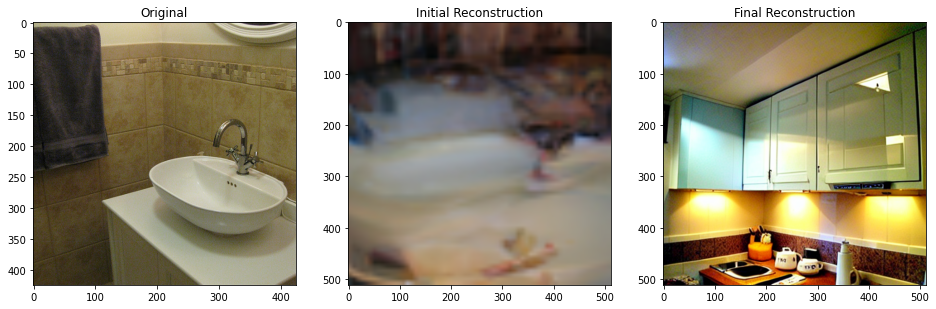

In [260]:
idx=3

fig,axs=plt.subplots(1,3,figsize=(16,8))
axs[0].imshow(y[idx].permute(1,2,0))
axs[1].imshow(guess_img[idx].permute(1,2,0))
axs[2].imshow(image_generated[idx])

axs[0].set_title("Original")
axs[1].set_title("Initial Reconstruction")
axs[2].set_title("Final Reconstruction")



In [275]:
# img_emb=torch.stack(img_emb,1)
# txt_emb=torch.stack(txt_emb,1)


In [276]:
# with torch.no_grad():

    
#     # guess_img=upsample(autoencoder.decoder.double()(z.to(device)).cpu())
#     guess_img=decode_with_partial_sampling(vae.decoder,{k:v.to(device).float() for k,v in z.items()},keep=len(x))
#     # img_out=pipe_embed.vae.float().decode(z.float().to(device)).sample.cpu()
#     print(guess_img.max())
#     guess_img=upsample(guess_img).clamp(0,1)

tensor(1.)


In [277]:
# guessed=[to_pil(i) for i in guess_img]

In [278]:
# uimg=pipe_embed._encode_image_prompt([null_img],device=device,num_images_per_prompt=num_images_per_prompt,do_classifier_free_guidance=do_classifier_free_guidance).cpu()
# utxt=pipe_embed._encode_text_prompt([null_prompt],device=device,num_images_per_prompt=num_images_per_prompt,do_classifier_free_guidance=do_classifier_free_guidance).cpu()

In [279]:
# strength=7.5


In [280]:
# scale=pipe_embed.vae.config.scaling_factor

In [281]:
# with torch.no_grad():
#     encoded_latents=scale*pipe_embed.vae.encode((2*guess_img-1).to(device)).latent_dist.sample()

In [282]:
# noise = randn_tensor(encoded_latents.shape, device=device, dtype=encoded_latents.dtype)
# noisy_latents=pipe_embed.scheduler.add_noise(encoded_latents,noise,torch.tensor(37).long().to(device)).clamp(-4,4)
# # noisy_latents=pipe_embed.scheduler.add_noise(encoded_latents,torch.randn(encoded_latents.shape),torch.tensor(50).long())

In [283]:
# noisy_latents= (noisy_latents-noisy_latents.mean())/noisy_latents.std()

In [284]:
# final_latents=noise+scale*encoded_latents

In [285]:
# if strength>1:
#     bs=txt_emb.shape[0]
#     txt_cond=torch.cat([utxt.repeat(bs,1,1),txt_emb.float()],0)
    
#     img_cond=torch.cat([uimg.repeat(bs,1,1),img_emb.float()],0)
# else:
#     txt_cond=txt_emb.float()
#     img_cond=img_emb.float()
    
# image_generated = pipe_embed([null_prompt]*bs,guessed,txt_cond.to(device), img_cond.to(device), text_to_image_strength=0.2,num_inference_steps=37,guidance_scale=9,latents=final_latents).images

100%|████████████████████████████████████████████████████████████| 37/37 [00:23<00:00,  1.56it/s]


### Compute Semantic Clusters and sample images to generate

## Save all the images to wandb

In [ ]:
x_norm=test_fmri_norm

In [ ]:
how_many=1
cols=["Shown","Initial Guess"] + [f"Reconstruction {i+1}" for i in range(how_many)]
table = wandb.Table(columns=cols)


In [ ]:
if adjust:
    z=get_latents(x_norm.numpy(),brain_to_latent,shapes,adjust=latent_adjust_values)
else:
    z=get_latents(x_norm.numpy(),brain_to_latent,shapes)
img_emb=[]
txt_emb=[]
for i in tqdm.tqdm(range(max_len_img)):
    emb=torch.tensor(brain_to_img_emb[i].predict(x_norm.numpy()))
    # print(emb.shape)
    if adjust and len(x)>1:
        #compute actual mean and std
        emb_mean=emb.mean(0)
        emb_std=emb.std(0)
        
        emb= (emb-emb_mean)/emb_std
        emb = emb*clip_img_embeds_std[i]+clip_img_embeds_mean[i]
    
    img_emb.append(emb)
    
for i in tqdm.tqdm(range(max_len_txt)):


    emb=torch.tensor(brain_to_txt_emb[i].predict(x_norm.numpy()))
    
    if adjust and len(x)>1:
        #compute actual mean and std
        emb_mean=emb.mean(0)
        emb_std=emb.std(0)
        
        emb= (emb-emb_mean)/emb_std
        
        emb = emb*clip_txt_embeds_std[i]+clip_txt_embeds_mean[i]
    txt_emb.append(emb)
img_emb=torch.stack(img_emb,1)
txt_emb=torch.stack(txt_emb,1)


In [ ]:

with torch.no_grad():


    # guess_img=upsample(autoencoder.decoder.double()(z.to(device)).cpu())
    guess_img=decode_with_partial_sampling(vae.decoder,{k:v.to(device).float() for k,v in z.items()},keep=len(x_norm))
    # img_out=pipe_embed.vae.float().decode(z.float().to(device)).sample.cpu()
    print(guess_img.max())
    guess_img=upsample(guess_img).clamp(0,1)

In [ ]:
uimg=pipe_embed._encode_image_prompt([null_img],device=device,num_images_per_prompt=num_images_per_prompt,do_classifier_free_guidance=do_classifier_free_guidance).cpu()
utxt=pipe_embed._encode_text_prompt([null_prompt],device=device,num_images_per_prompt=num_images_per_prompt,do_classifier_free_guidance=do_classifier_free_guidance).cpu()

In [ ]:
guessed=[to_pil(i) for i in guess_img]

In [ ]:
if decode_all_test_set:
    for i in range(len(x_norm)):

    
        print(f"[INFO] Generating {i+1}/{len(x_norm)}")
        with torch.no_grad():
            encoded_latents=scale*pipe_embed.vae.encode((2*guess_img[i:i+1]-1).to(device)).latent_dist.sample()
            noise = randn_tensor((how_many,encoded_latents.shape[1],encoded_latents.shape[2],encoded_latents.shape[3]), device=device, dtype=encoded_latents.dtype)
            encoded_latents_norm=(encoded_latents-encoded_latents.mean())//(1e-8+encoded_latents.std())
            #final_latents=pipe_embed.scheduler.add_noise(0.0*(encoded_latents_norm.clamp(-3,3)),noise,torch.tensor(50).long().to(device))
            
            #final_latents=noise+0.18*encoded_latents_norm.clamp(-3,3)
            final_latents=noise+scale*encoded_latents.clamp(-3,3)
            final_latents = (final_latents - final_latents.mean())/final_latents.std()

            
            if strength>1:
                txt_cond=torch.cat([utxt.repeat(how_many,1,1),txt_emb[i:i+1].float().repeat(how_many,1,1)],0)

                img_cond=torch.cat([uimg.repeat(how_many,1,1),img_emb[i:i+1].float().repeat(how_many,1,1)],0)
            else:
                txt_cond=txt_emb[i:i+1].float().repeat(how_many,1,1)
                img_cond=img_emb[i:i+1].float().repeat(how_many,1,1)
            
            # print(txt_emb[i:i+1].float().repeat(how_many,1,1).shape,img_emb[i:i+1].float().repeat(how_many,1,1).shape,final_latents.shape)
            
            # image_generated = pipe_embed([null_prompt]*bs,guessed,txt_cond.to(device), img_cond.to(device), text_to_image_strength=0.4,num_inference_steps=37,guidance_scale=strength,latents=final_latents).images
            image_generated = pipe_embed([null_prompt]*how_many,[null_img]*how_many,txt_cond.to(device), img_cond.to(device), text_to_image_strength=0.4,num_inference_steps=37,guidance_scale=strength,latents=final_latents).images
            imgs=(test_imgs[i].permute(1,2,0).numpy(), guessed[i], *image_generated)
            imgs=(wandb.Image(x) for x in imgs)
            table.add_data(*imgs)

In [ ]:
encoded_latents

In [ ]:
wandb.log({"table":table})

In [ ]:
print("end of image decoding")

In [ ]:
stop

## Check images for comparison


In [ ]:
# fig,axs=plt.subplots(5,10,figsize=(20,10))

# offset = 200

# for i, ax in enumerate(axs.ravel()):
#     ax.imshow(test_imgs[i + offset].permute(1, 2, 0))
#     ax.set_title(i + offset)
#     ax.axis('off')  # Remove axes
#     ax.set_xticks([])  # Remove x-axis ticks
#     ax.set_yticks([])  # Remove y-axis ticks

# plt.grid(False)  # Remove grid
# plt.subplots_adjust(hspace=0.5)
# plt.show()


In [ ]:
# indices=[25,31,68,121,126,318,384,492,531,606,702,860]

# indices2=[70,116,165,261,278,363,451,774]
# indices3=[41,205,230,411,428,446,502,777]
# extra=[95,905]

In [ ]:
## Encoding Model - Text from CLS token

## Encoding Model - Text from CLS token

In [ ]:
train=True

In [ ]:
os.makedirs(f"models/{sub}/encoding",exist_ok=True)
os.makedirs(f"models/{sub}/encoding/from_text",exist_ok=True)
os.makedirs(f"models/{sub}/encoding/from_img",exist_ok=True)


In [ ]:
# Load English stopwords from NLTK
stopwords_english = stopwords.words('english')

# Function to remove punctuation and stopwords from a string
def remove_punctuation_and_stopwords(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text into words
    words = nltk.word_tokenize(text)
    # Remove stopwords
    words = [word for word in words if word.lower() not in stopwords_english]
    # Join words back into a string
    cleaned_text = ' '.join(words)
    return cleaned_text



In [ ]:
mini_batch=64
train_clip_txt_cls=[]
for i in tqdm.tqdm(range(int(np.ceil(len(train_captions)/mini_batch)))):
    with torch.no_grad():
        inputs=pipe_embed.tokenizer(train_captions[mini_batch*i:mini_batch*(i+1)],padding=True,return_tensors="pt").to(device)
        outputs=pipe_embed.text_encoder.text_model(**inputs)
        train_clip_txt_cls.append(outputs.pooler_output.cpu())
train_clip_txt_cls=torch.cat(train_clip_txt_cls,0)

In [ ]:
mini_batch=64
test_clip_txt_cls=[]
for i in tqdm.tqdm(range(int(np.ceil(len(test_captions)/mini_batch)))):
    with torch.no_grad():
        inputs=pipe_embed.tokenizer(test_captions[mini_batch*i:mini_batch*(i+1)],padding=True,return_tensors="pt").to(device)
        outputs=pipe_embed.text_encoder.text_model(**inputs)
        test_clip_txt_cls.append(outputs.pooler_output.cpu())
test_clip_txt_cls=torch.cat(test_clip_txt_cls,0)

In [ ]:
# txt_to_fmri=Ridge(alpha=5e3,max_iter=10000,fit_intercept=True)
# txt_to_fmri.fit(train_clip_txt_cls.numpy(),train_fmri_norm.numpy())

In [ ]:
# txt_to_fmri=Ridge(alpha=5e4,max_iter=10000,fit_intercept=True)
# txt_to_fmri.fit(train_clip_txt_cls.numpy(),train_fmri.numpy())

In [ ]:
txt_to_fmri_norm=Ridge(alpha=5e4,max_iter=10000,fit_intercept=True)
txt_to_fmri_norm.fit(train_clip_txt_cls.numpy(),train_fmri_norm.numpy())

In [ ]:
filename = f'txt_to_fmri_norm.sav'
with open(opj(f"models/{sub}/encoding",filename), 'wb') as f:
    pickle.dump(txt_to_fmri_norm, f)

In [ ]:



if train:
    txt_to_fmri=Ridge(alpha=5e4,max_iter=10000,fit_intercept=True)
    txt_to_fmri.fit(train_clip_txt_cls.numpy(),train_fmri.numpy())

    filename = f'txt_to_fmri.sav'
    with open(opj(f"models/{sub}/encoding",filename), 'wb') as f:
        pickle.dump(txt_to_fmri, f)
else:
    with open(opj(f"models/{sub}/encoding","txt_to_fmri.sav"), 'rb') as f:
        p=pickle.load(f)
        txt_to_fmri=p

In [ ]:
os.makedirs(f"models/{sub}/encoding",exist_ok=True)

filename = f'txt_to_fmri.sav'
with open(opj(f"models/{sub}/encoding",filename), 'wb') as f:
    pickle.dump(txt_to_fmri, f)

In [ ]:
idx1=np.random.randint(len(test_dataset))
idx2=np.random.randint(len(test_dataset))
idx3=np.random.randint(len(test_dataset))
idx4=np.random.randint(len(test_dataset))

_,y1,c1=test_dataset.__getitem__(idx1)

_,y2,c2=test_dataset.__getitem__(idx2)

_,y3,c3=test_dataset.__getitem__(idx3)

_,y4,c4=test_dataset.__getitem__(idx4)


c=[c1,c2,c3,c4]
y=[y1,y2,y3,y4]

In [ ]:

with torch.no_grad():
    
    inputs=pipe_embed.tokenizer(c,padding=True,return_tensors="pt").to(device)
    outputs=pipe_embed.text_encoder.text_model(**inputs)
    text_encoded=outputs.pooler_output.cpu().numpy()
    
    # text_encoded=pipe_embed._encode_text_prompt(c,device=device,num_images_per_prompt=num_images_per_prompt,do_classifier_free_guidance=do_classifier_free_guidance).cpu()
    # text_encoded=text_encoded.reshape(len(text_encoded),-1)

    x_predicted=torch.tensor(txt_to_fmri.predict(text_encoded))

In [ ]:
x_predicted.mean()

In [ ]:
if adjust:
    # x_predicted_adj=(x_predicted-x_predicted.mean(0))/(x_predicted.std(0))
    # x_predicted=x_predicted_adj*train_fmri_std+train_fmri_mean
    x_predicted=(x_predicted-train_fmri_mean)/train_fmri_std

In [ ]:
x_predicted.mean()

In [ ]:
#just for this example

z=get_latents(x_predicted.numpy(),brain_to_latent,shapes,adjust=latent_adjust_values)

img_emb=[]
txt_emb=[]
for i in tqdm.tqdm(range(max_len_img)):
    emb=torch.tensor(brain_to_img_emb[i].predict(x_predicted.numpy()))

    img_emb.append(emb)
    
for i in tqdm.tqdm(range(max_len_txt)):


    emb=torch.tensor(brain_to_txt_emb[i].predict(x_predicted.numpy()))
    
    txt_emb.append(emb)
    
# adjust=True

In [ ]:
img_emb=torch.stack(img_emb,1)
txt_emb=torch.stack(txt_emb,1)

with torch.no_grad():

    
    # guess_img=upsample(autoencoder.decoder.double()(z.to(device)).cpu())
    guess_img=decode_with_partial_sampling(vae.decoder,{k:v.to(device).float() for k,v in z.items()},keep=len(c))
    # img_out=pipe_embed.vae.float().decode(z.float().to(device)).sample.cpu()
    print(guess_img.max())
    guess_img=upsample(guess_img).clamp(0,1)
    guessed=[to_pil(i) for i in guess_img]
    
uimg=pipe_embed._encode_image_prompt([null_img],device=device,num_images_per_prompt=num_images_per_prompt,do_classifier_free_guidance=do_classifier_free_guidance).cpu()
utxt=pipe_embed._encode_text_prompt([null_prompt],device=device,num_images_per_prompt=num_images_per_prompt,do_classifier_free_guidance=do_classifier_free_guidance).cpu()

In [ ]:
with torch.no_grad():
    bs=len(guessed)
    
    encoded_latents=scale*pipe_embed.vae.encode((2*guess_img-1).to(device)).latent_dist.sample()
    noise = randn_tensor((bs,encoded_latents.shape[1],encoded_latents.shape[2],encoded_latents.shape[3]), device=device, dtype=encoded_latents.dtype)
    encoded_latents_norm=(encoded_latents-encoded_latents.mean())//(1e-8+encoded_latents.std())
    #final_latents=pipe_embed.scheduler.add_noise(0.0*(encoded_latents_norm.clamp(-3,3)),noise,torch.tensor(50).long().to(device))

    
    
    
    final_latents=noise+0.18*encoded_latents.clamp(-3,3)
    if strength>1:
        txt_cond=torch.cat([utxt.repeat(bs,1,1),txt_emb.float()],0)

        img_cond=torch.cat([uimg.repeat(bs,1,1),img_emb.float()],0)
    else:
        txt_cond=txt_emb[i:i+1].float()
        img_cond=img_emb[i:i+1].float()


    image_generated = pipe_embed([null_prompt]*bs,[null_img]*bs,txt_cond.to(device), img_cond.to(device), text_to_image_strength=0.4,num_inference_steps=37,guidance_scale=7.5,latents=final_latents).images

In [ ]:
fig,axs=plt.subplots(1,3,figsize=(16,8))

idx=3

axs[0].imshow(y[idx].permute(1,2,0))

axs[1].imshow(guess_img[idx].permute(1,2,0))


axs[2].imshow(image_generated[idx])

axs[1].set_title("Initial Reconstruction") 

axs[2].set_title("Final Reconstruction")
fig.suptitle(f"Encoding text: \n{c[idx]}")

### Predict the whole test set

In [ ]:
captions=[]
fmri_predicted=[]
fmri_true=[]
text_clip=[]
with torch.no_grad():
    for x,y,c in tqdm.tqdm(test_dataloader):
        
            
        inputs=pipe_embed.tokenizer(c,padding=True,return_tensors="pt").to(device)
        outputs=pipe_embed.text_encoder.text_model(**inputs)
        text_encoded=outputs.pooler_output.cpu().numpy()

        # text_encoded=pipe_embed._encode_text_prompt(c,device=device,num_images_per_prompt=num_images_per_prompt,do_classifier_free_guidance=do_classifier_free_guidance).cpu()
        # text_encoded=text_encoded.reshape(len(text_encoded),-1)

        x_predicted=torch.tensor(txt_to_fmri.predict(text_encoded))
        fmri_true.append(x)
        # text_encoded=pipe_embed._encode_text_prompt(c,device=device,num_images_per_prompt=num_images_per_prompt,do_classifier_free_guidance=do_classifier_free_guidance).cpu()
        # text_encoded=text_encoded.reshape(len(text_encoded),-1)
        text_clip.append(text_encoded)
        fmri_predicted.append(x_predicted)
        captions.append(c)

In [ ]:
captions_tmp=[]
for i in captions:
    captions_tmp+=i
captions=captions_tmp
fmri_predicted=torch.cat(fmri_predicted,0)
fmri_true=torch.cat(fmri_true,0)


In [ ]:
torch.save(fmri_predicted,f"models/{sub}/fmri_predicted_from_text.pt")
torch.save(fmri_true,f"models/{sub}/fmri_true.pt")


if adjust:
    # fmri_predicted_adj=(fmri_predicted-fmri_predicted.mean(0))/fmri_predicted.std(0)
    # fmri_predicted_adj= train_fmri_std*fmri_predicted_adj+train_fmri_mean
    fmri_predicted_adj=(fmri_predicted-train_fmri_mean)/train_fmri_std
    
    torch.save(fmri_predicted_adj,f"models/{sub}/fmri_predicted_adjusted.pt")
    
    fmri_true_adj=(fmri_true-train_fmri_mean)/train_fmri_std

    torch.save(fmri_true_adj,f"models/{sub}/fmri_true_adjusted.pt")


with open(f"models/{sub}/test_captions_txt.sav", "wb") as fp:   #Pickling
    pickle.dump(test_captions, fp)

### Encode and decode all test set captions

In [ ]:
predicted_cliptext_from_text={}
predicted_clipvision_from_text={}


In [ ]:
if adjust:
    z=get_latents(fmri_predicted_adj.numpy(),brain_to_latent,shapes,adjust=latent_adjust_values)
else:
    z=get_latents(fmri_predicted_adj.numpy(),brain_to_latent,shapes)
img_emb=[]
txt_emb=[]
for i in tqdm.tqdm(range(max_len_img)):
    emb=torch.tensor(brain_to_img_emb[i].predict(fmri_predicted_adj.numpy()))
    # print(emb.shape)
    if adjust and len(x)>1:
        #compute actual mean and std
        emb_mean=emb.mean(0)
        emb_std=emb.std(0)
        
        emb= (emb-emb_mean)/emb_std
        emb = emb*clip_img_embeds_std[i]+clip_img_embeds_mean[i]
    
    # emb_mean_txt=emb_mean
    # emb_std_txt=emb_std
    predicted_clipvision_from_text[i]={"emb_mean":emb_mean,"emb_std":emb_std}
    img_emb.append(emb)
    
for i in tqdm.tqdm(range(max_len_txt)):


    emb=torch.tensor(brain_to_txt_emb[i].predict(fmri_predicted_adj.numpy()))
    
    if adjust and len(x)>1:
        #compute actual mean and std
        emb_mean=emb.mean(0)
        emb_std=emb.std(0)
        
        emb= (emb-emb_mean)/emb_std
        
        emb = emb*clip_txt_embeds_std[i]+clip_txt_embeds_mean[i]
    txt_emb.append(emb)
    
    predicted_cliptext_from_text[i]={"emb_mean":emb_mean,"emb_std":emb_std}
    
    # emb_mean_img=emb_mean
    # emb_std_img=emb_std
img_emb=torch.stack(img_emb,1)
txt_emb=torch.stack(txt_emb,1)


In [ ]:
# just saving the latents predicted statistics

txt_stats={}
for k,v in brain_to_latent.items():
    s=shapes[k]
    tmp_z=torch.tensor(v.predict(fmri_predicted_adj.numpy())).reshape(-1,*s)
    txt_stats[k]={"mean":tmp_z.mean(0), "std": tmp_z.std(0), "shape": s}

with open(f"models/{sub}/encoding/from_text/stats.sav","wb") as f:
    pickle.dump(txt_stats,f)
f.close()

In [ ]:
# a=predicted_cliptext_from_text
# predicted_cliptext_from_text=predicted_clipvision_from_text
# predicted_clipvision_from_text=a

In [ ]:
if compute_dataset:
    with open(f"models/{sub}/encoding/from_text/emb_txt_from_txt.sav","wb") as f:
        pickle.dump(predicted_cliptext_from_text,f)
    f.close()

    with open(f"models/{sub}/encoding/from_text/emb_img_from_txt.sav","wb") as f:
        pickle.dump(predicted_clipvision_from_text,f)
    f.close()
    

    torch.save(fmri_predicted_adj.mean(0), f"models/{sub}/encoding/fmri_predicted_adj_mean.pt")
    torch.save(fmri_predicted_adj.std(0), f"models/{sub}/encoding/fmri_predicted_adj_std.pt")



In [ ]:
how_many=1
cols=["Caption","Reference","Initial Guess"] + [f"Reconstruction {i+1}" for i in range(how_many)]
table_txt= wandb.Table(columns=cols)


In [ ]:

with torch.no_grad():


    # guess_img=upsample(autoencoder.decoder.double()(z.to(device)).cpu())
    guess_img=decode_with_partial_sampling(vae.decoder,{k:v.to(device).float() for k,v in z.items()},keep=len(x_norm))
    # img_out=pipe_embed.vae.float().decode(z.float().to(device)).sample.cpu()
    print(guess_img.max())
    guess_img=upsample(guess_img).clamp(0,1)
    
    uimg=pipe_embed._encode_image_prompt([null_img],device=device,num_images_per_prompt=num_images_per_prompt,do_classifier_free_guidance=do_classifier_free_guidance).cpu()
    utxt=pipe_embed._encode_text_prompt([null_prompt],device=device,num_images_per_prompt=num_images_per_prompt,do_classifier_free_guidance=do_classifier_free_guidance).cpu()
guessed=[to_pil(i) for i in guess_img]

In [ ]:
if decode_all_test_set:
    for i in range(len(fmri_predicted_adj)):
    # for i in range(4):
    
        print(f"[INFO] Generating {i+1}/{len(x_norm)}")
        with torch.no_grad():
            encoded_latents=scale*pipe_embed.vae.encode((2*guess_img[i:i+1]-1).to(device)).latent_dist.sample()
            noise = randn_tensor((how_many,encoded_latents.shape[1],encoded_latents.shape[2],encoded_latents.shape[3]), device=device, dtype=encoded_latents.dtype)
            encoded_latents_norm=(encoded_latents-encoded_latents.mean())//(1e-8+encoded_latents.std())
            #final_latents=pipe_embed.scheduler.add_noise(0.0*(encoded_latents_norm.clamp(-3,3)),noise,torch.tensor(50).long().to(device))
            
            final_latents=noise+scale*encoded_latents_norm.clamp(-3,3)
            final_latents = (final_latents - final_latents.mean())/final_latents.std()

            if strength>1:
                txt_cond=torch.cat([utxt.repeat(how_many,1,1),txt_emb[i:i+1].float().repeat(how_many,1,1)],0)

                img_cond=torch.cat([uimg.repeat(how_many,1,1),img_emb[i:i+1].float().repeat(how_many,1,1)],0)
            else:
                txt_cond=txt_emb[i:i+1].float().repeat(how_many,1,1)
                img_cond=img_emb[i:i+1].float().repeat(how_many,1,1)
            
            # print(txt_emb[i:i+1].float().repeat(how_many,1,1).shape,img_emb[i:i+1].float().repeat(how_many,1,1).shape,final_latents.shape)
            
            # image_generated = pipe_embed([null_prompt]*bs,guessed,txt_cond.to(device), img_cond.to(device), text_to_image_strength=0.4,num_inference_steps=37,guidance_scale=strength,latents=final_latents).images
            image_generated = pipe_embed([null_prompt]*how_many,[null_img]*how_many,txt_cond.to(device), img_cond.to(device), text_to_image_strength=0.4,num_inference_steps=37,guidance_scale=strength,latents=final_latents).images
            imgs=(test_imgs[i].permute(1,2,0).numpy(), guessed[i], *image_generated)
            imgs=(wandb.Image(x) for x in imgs)
            table_txt.add_data(test_captions[i],*imgs)

In [ ]:
wandb.log({"table_txt":table_txt})

In [ ]:
print("end of text to image generation")

### Clustering of txt_cls

In [ ]:
# visualizerl = KMeans()
# visualizer = KElbowVisualizer(model, k=(2,12))

# visualizer.fit(val_clip_txt_cls.numpy())        # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

In [ ]:
# kmeans=KMeans(n_clusters=6).fit(train_clip_txt_cls.numpy())

In [ ]:
# clusters=kmeans.predict(test_clip_txt_cls.numpy())

In [ ]:
# np.savetxt(os.path.join(f"models/{sub}", f"cluster_txt.txt"),clusters)

In [ ]:
# test_clip_txt_cls.numpy().shape

In [ ]:
# X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(test_clip_txt_cls.numpy().astype(np.float64))

In [ ]:
# sns.scatterplot(X_embedded[:,0],X_embedded[:,1],c=clusters,cmap="tab10")

In [ ]:
# # Process each string in the input list
# cleaned_list = []
# for text in test_captions:
#     cleaned_text = remove_punctuation_and_stopwords(text)
#     cleaned_list.append(cleaned_text)


In [ ]:
# cl=0
# wc = WordCloud(background_color="white", max_words=2000, contour_width=3, contour_color='steelblue')

# # generate word cloud
# wc.generate(" ".join(list(np.array(cleaned_list)[clusters==cl])))

# # store to file
# wc.to_file(os.path.join(f"models/{sub}", f"cluster_{cl}.png"))

# # show
# plt.imshow(wc, interpolation='bilinear')
# plt.axis("off")

In [ ]:
# table_txt.data

## Encoding Model - Images
Same reasoning used for text encoding
Compute the CLS token and use it

In [125]:
processor=pipe_embed.image_feature_extractor
clipvision=pipe_embed.image_encoder

In [126]:
train_clip_img_cls=[]
for i in tqdm.tqdm(range(int(np.ceil(len(train_imgs)/mini_batch)))):
    with torch.no_grad():
        batch_imgs=[to_pil(i) for i in train_imgs[mini_batch*i:mini_batch*(i+1)]]
        inputs=processor(batch_imgs,return_tensors="pt").to(device)
        outputs=clipvision(inputs.pixel_values).image_embeds.cpu()
        train_clip_img_cls.append(outputs)
train_clip_img_cls=torch.cat(train_clip_img_cls,0)

100%|██████████████████████████████████████████████████████████| 139/139 [22:27<00:00,  9.70s/it]


In [127]:
test_clip_img_cls=[]
for i in tqdm.tqdm(range(int(np.ceil(len(test_imgs)/mini_batch)))):
    with torch.no_grad():
        batch_imgs=[to_pil(i) for i in test_imgs[mini_batch*i:mini_batch*(i+1)]]
        inputs=processor(batch_imgs,return_tensors="pt").to(device)
        outputs=clipvision(inputs.pixel_values).image_embeds.cpu()
        test_clip_img_cls.append(outputs)
test_clip_img_cls=torch.cat(test_clip_img_cls,0)

100%|████████████████████████████████████████████████████████████| 16/16 [02:42<00:00, 10.17s/it]


In [128]:
os.makedirs(f"models/{sub}/encoding",exist_ok=True)
if train:
    img_to_fmri=Ridge(alpha=5e3,max_iter=10000,fit_intercept=True)
    img_to_fmri.fit(train_clip_img_cls.numpy(),train_fmri.numpy())

    filename = f'img_to_fmri.sav'
    with open(opj(f"models/{sub}/encoding",filename), 'wb') as f:
        pickle.dump(img_to_fmri, f)
else:
    with open(opj(f"models/{sub}/encoding","img_to_fmri.sav"), 'rb') as f:
        p=pickle.load(f)
        img_to_fmri=p

In [129]:
idx1=np.random.randint(len(test_dataset))
idx2=np.random.randint(len(test_dataset))
idx3=np.random.randint(len(test_dataset))

_,y1,c1=test_dataset.__getitem__(idx1)

_,y2,c2=test_dataset.__getitem__(idx2)

_,y3,c3=test_dataset.__getitem__(idx3)

c=[c1,c2,c3]
y=[y1,y2,y3]

In [130]:

with torch.no_grad():
    img_encoded=processor([to_pil(i) for i in y],return_tensors="pt").to(device)
    img_encoded=clipvision(img_encoded.pixel_values).image_embeds.cpu().numpy()

    x_predicted=torch.tensor(img_to_fmri.predict(img_encoded))
    
    if adjust:
        x_predicted=(x_predicted-train_fmri_mean)/train_fmri_std

In [131]:
#just for this example

z=get_latents(x_predicted.numpy(),brain_to_latent,shapes,adjust=latent_adjust_values)

img_emb=[]
txt_emb=[]
for i in tqdm.tqdm(range(max_len_img)):
    emb=torch.tensor(brain_to_img_emb[i].predict(x_predicted.numpy()))
    # print(emb.shape)
#     if adjust and len(x)>1:
#         #compute actual mean and std
#         emb_mean=emb.mean(0)
#         emb_std=emb.std(0)
        
#         emb= (emb-emb_mean)/emb_std
#         emb = emb*clip_img_embeds_std[i]+clip_img_embeds_mean[i]
    
    img_emb.append(emb)
    
for i in tqdm.tqdm(range(max_len_txt)):


    emb=torch.tensor(brain_to_txt_emb[i].predict(x_predicted.numpy()))
    
#     if adjust and len(x)>1:
#         #compute actual mean and std
#         emb_mean=emb.mean(0)
#         emb_std=emb.std(0)
        
#         emb= (emb-emb_mean)/emb_std
        
#         emb = emb*clip_txt_embeds_std[i]+clip_txt_embeds_mean[i]
    txt_emb.append(emb)
    
img_emb=torch.stack(img_emb,1)
txt_emb=torch.stack(txt_emb,1)

100%|████████████████████████████████████████████████████████████| 77/77 [00:10<00:00,  7.43it/s]


In [132]:
with torch.no_grad():

    
    # guess_img=upsample(autoencoder.decoder.double()(z.to(device)).cpu())
    guess_img=decode_with_partial_sampling(vae.decoder,{k:v.to(device).float() for k,v in z.items()},keep=len(c))
    # img_out=pipe_embed.vae.float().decode(z.float().to(device)).sample.cpu()
    print(guess_img.max())
    guess_img=upsample(guess_img).clamp(0,1)
    guessed=[to_pil(i) for i in guess_img]

tensor(0.9961)


/home/matteo/anaconda3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [133]:
uimg=pipe_embed._encode_image_prompt([null_img],device=device,num_images_per_prompt=num_images_per_prompt,do_classifier_free_guidance=do_classifier_free_guidance).cpu()
utxt=pipe_embed._encode_text_prompt([null_prompt],device=device,num_images_per_prompt=num_images_per_prompt,do_classifier_free_guidance=do_classifier_free_guidance).cpu()

In [134]:
with torch.no_grad():
    bs=len(guessed)
    
    encoded_latents=scale*pipe_embed.vae.encode((2*guess_img-1).to(device)).latent_dist.sample()
    noise = randn_tensor((bs,encoded_latents.shape[1],encoded_latents.shape[2],encoded_latents.shape[3]), device=device, dtype=encoded_latents.dtype)
    encoded_latents_norm=(encoded_latents-encoded_latents.mean())//(1e-8+encoded_latents.std())
    #final_latents=pipe_embed.scheduler.add_noise(0.0*(encoded_latents_norm.clamp(-3,3)),noise,torch.tensor(50).long().to(device))

    final_latents=noise+0.18*encoded_latents_norm.clamp(-3,3)
    if strength>1:
        txt_cond=torch.cat([utxt.repeat(bs,1,1),txt_emb.float()],0)

        img_cond=torch.cat([uimg.repeat(bs,1,1),img_emb.float()],0)
    else:
        txt_cond=txt_emb.float()
        img_cond=img_emb.float()


    image_generated = pipe_embed([null_prompt]*bs,[null_img]*bs,txt_cond.to(device), img_cond.to(device), text_to_image_strength=0.4,num_inference_steps=37,guidance_scale=strength,latents=final_latents).images

  0%|          | 0/37 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Encoding image with description:\na baseball player swinging a bat on top of a green field.')

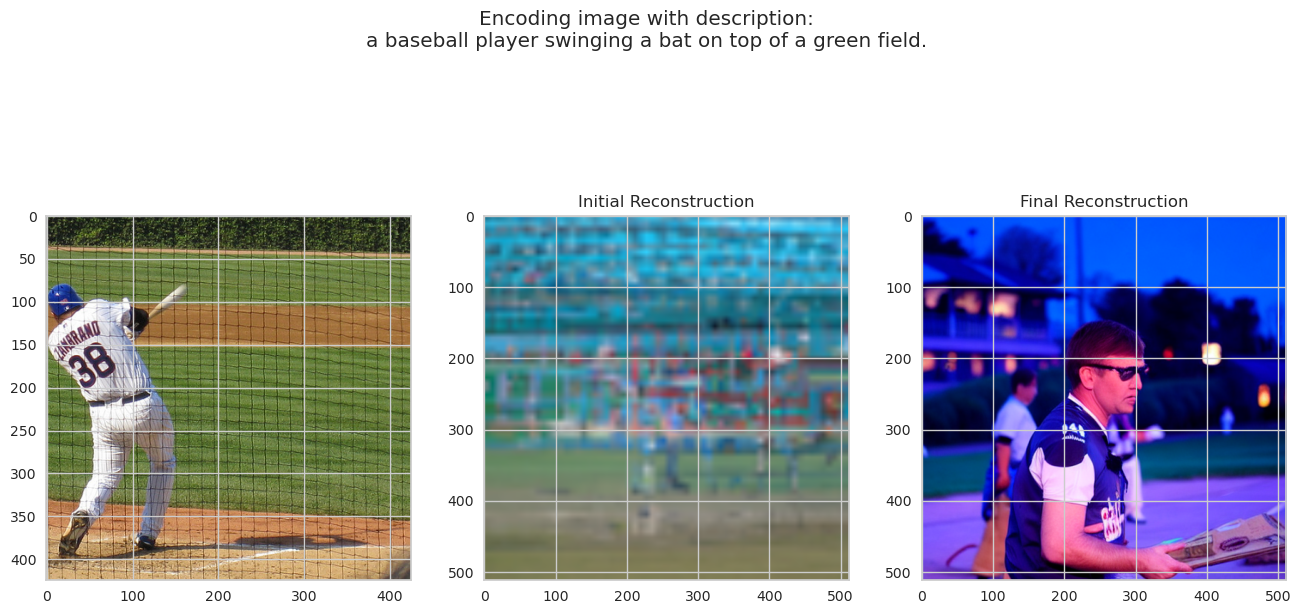

In [135]:
fig,axs=plt.subplots(1,3,figsize=(16,8))

idx=2

axs[0].imshow(y[idx].permute(1,2,0))

axs[1].imshow(guess_img[idx].permute(1,2,0))


axs[2].imshow(image_generated[idx])

axs[1].set_title("Initial Reconstruction") 

axs[2].set_title("Final Reconstruction")
fig.suptitle(f"Encoding image with description:\n{c[idx]}")

## Predict the whole test set

In [136]:
fmri_predicted_from_img=[]
fmri_true_img=[]
img_clip=[]
images=[]
with torch.no_grad():
    for x,y,c in tqdm.tqdm(test_dataloader):
        
            
        batch_imgs=[to_pil(i) for i in y]
        inputs=processor(batch_imgs,return_tensors="pt").to(device)
        img_encoded=clipvision(inputs.pixel_values).image_embeds.cpu().numpy()

        # text_encoded=pipe_embed._encode_text_prompt(c,device=device,num_images_per_prompt=num_images_per_prompt,do_classifier_free_guidance=do_classifier_free_guidance).cpu()
        # text_encoded=text_encoded.reshape(len(text_encoded),-1)

        x_predicted=torch.tensor(img_to_fmri.predict(img_encoded))
        fmri_true_img.append(x)
        # text_encoded=pipe_embed._encode_text_prompt(c,device=device,num_images_per_prompt=num_images_per_prompt,do_classifier_free_guidance=do_classifier_free_guidance).cpu()
        # text_encoded=text_encoded.reshape(len(text_encoded),-1)
        img_clip.append(img_encoded)
        fmri_predicted_from_img.append(x_predicted)
        images.append(y)

100%|██████████████████████████████████████████████████████████| 246/246 [08:35<00:00,  2.10s/it]


In [137]:
fmri_predicted_from_img=torch.cat(fmri_predicted_from_img,0)
fmri_true_img=torch.cat(fmri_true_img,0)


In [138]:
torch.save(fmri_predicted_from_img,f"models/{sub}/fmri_predicted_from_img.pt")
torch.save(fmri_true_img,f"models/{sub}/fmri_true_img.pt")


if adjust:
    # fmri_predicted_adj=(fmri_predicted-fmri_predicted.mean(0))/fmri_predicted.std(0)
    # fmri_predicted_adj= train_fmri_std*fmri_predicted_adj+train_fmri_mean
    fmri_predicted_img_adj=(fmri_predicted_from_img-train_fmri_mean)/train_fmri_std
    
    torch.save(fmri_predicted_img_adj,f"models/{sub}/fmri_predicted_img_adjusted.pt")
    
    fmri_true_img_adj=(fmri_true_img-train_fmri_mean)/train_fmri_std

    torch.save(fmri_true_img_adj,f"models/{sub}/fmri_true_img_adjusted.pt")

## Final predictions

In [139]:
predicted_cliptext_from_img={}
predicted_clipvision_from_img={}

In [140]:
if adjust:
    z=get_latents(fmri_predicted_img_adj.numpy(),brain_to_latent,shapes,adjust=latent_adjust_values)
else:
    z=get_latents(fmri_predicted_img_adj.numpy(),brain_to_latent,shapes)
img_emb=[]
txt_emb=[]
for i in tqdm.tqdm(range(max_len_img)):
    emb=torch.tensor(brain_to_img_emb[i].predict(fmri_predicted_img_adj.numpy()))
    # print(emb.shape)
    if adjust and len(x)>1:
        #compute actual mean and std
        emb_mean=emb.mean(0)
        emb_std=emb.std(0)
        
        emb= (emb-emb_mean)/emb_std
        emb = emb*clip_img_embeds_std[i]+clip_img_embeds_mean[i]
        
        predicted_clipvision_from_img[i]={"emb_mean":emb_mean,"emb_std":emb_std}

    img_emb.append(emb)
    
for i in tqdm.tqdm(range(max_len_txt)):


    emb=torch.tensor(brain_to_txt_emb[i].predict(fmri_predicted_img_adj.numpy()))
    
    if adjust and len(x)>1:
        #compute actual mean and std
        emb_mean=emb.mean(0)
        emb_std=emb.std(0)
        
        emb= (emb-emb_mean)/emb_std
        
        emb = emb*clip_txt_embeds_std[i]+clip_txt_embeds_mean[i]
        predicted_cliptext_from_img[i]={"emb_mean":emb_mean,"emb_std":emb_std}

    txt_emb.append(emb)
img_emb=torch.stack(img_emb,1)
txt_emb=torch.stack(txt_emb,1)


100%|████████████████████████████████████████████████████████████| 77/77 [01:09<00:00,  1.10it/s]


In [141]:
img_stats={}
for k,v in brain_to_latent.items():
    s=shapes[k]
    tmp_z=torch.tensor(v.predict(fmri_predicted_img_adj.numpy())).reshape(-1,*s)
    txt_stats[k]={"mean":tmp_z.mean(0), "std": tmp_z.std(0), "shape": s}

with open(f"models/{sub}/encoding/from_img/stats.sav","wb") as f:
    pickle.dump(img_stats,f)
f.close()

In [142]:
# if compute_dataset:
with open(f"models/{sub}/encoding/from_img/emb_txt_from_txt.sav","wb") as f:
    pickle.dump(predicted_cliptext_from_img,f)
f.close()

with open(f"models/{sub}/encoding/from_img/emb_img_from_txt.sav","wb") as f:
    pickle.dump(predicted_clipvision_from_img,f)
f.close()


torch.save(fmri_predicted_adj.mean(0), f"models/{sub}/encoding/fmri_predicted_adj_img_mean.pt")
torch.save(fmri_predicted_adj.std(0), f"models/{sub}/encoding/fmri_predicted_adj_img_std.pt")



In [143]:
how_many=1
cols=["Reference","Initial Guess"] + [f"Reconstruction {i+1}" for i in range(how_many)]
table_img= wandb.Table(columns=cols)


In [144]:

with torch.no_grad():


    # guess_img=upsample(autoencoder.decoder.double()(z.to(device)).cpu())
    guess_img=decode_with_partial_sampling(vae.decoder,{k:v.to(device).float() for k,v in z.items()},keep=len(x_norm))
    # img_out=pipe_embed.vae.float().decode(z.float().to(device)).sample.cpu()
    print(guess_img.max())
    guess_img=upsample(guess_img).clamp(0,1)
    
    uimg=pipe_embed._encode_image_prompt([null_img],device=device,num_images_per_prompt=num_images_per_prompt,do_classifier_free_guidance=do_classifier_free_guidance).cpu()
    utxt=pipe_embed._encode_text_prompt([null_prompt],device=device,num_images_per_prompt=num_images_per_prompt,do_classifier_free_guidance=do_classifier_free_guidance).cpu()
guessed=[to_pil(i) for i in guess_img]

tensor(1.)


/home/matteo/anaconda3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [145]:
if decode_all_test_set:
    for i in range(len(fmri_predicted_adj)):
    # for i in range(4):
    
        print(f"[INFO] Generating {i+1}/{len(x_norm)}")
        with torch.no_grad():
            encoded_latents=scale*pipe_embed.vae.encode((2*guess_img[i:i+1]-1).to(device)).latent_dist.sample()
            noise = randn_tensor((how_many,encoded_latents.shape[1],encoded_latents.shape[2],encoded_latents.shape[3]), device=device, dtype=encoded_latents.dtype)
            encoded_latents_norm=(encoded_latents-encoded_latents.mean())//(1e-8+encoded_latents.std())
            #final_latents=pipe_embed.scheduler.add_noise(0.0*(encoded_latents_norm.clamp(-3,3)),noise,torch.tensor(50).long().to(device))
            
            final_latents=noise+scale*encoded_latents_norm.clamp(-3,3)
            final_latents = (final_latents - final_latents.mean())/final_latents.std()

            if strength>1:
                txt_cond=torch.cat([utxt.repeat(how_many,1,1),txt_emb[i:i+1].float().repeat(how_many,1,1)],0)

                img_cond=torch.cat([uimg.repeat(how_many,1,1),img_emb[i:i+1].float().repeat(how_many,1,1)],0)
            else:
                txt_cond=txt_emb[i:i+1].float().repeat(how_many,1,1)
                img_cond=img_emb[i:i+1].float().repeat(how_many,1,1)
            
            # print(txt_emb[i:i+1].float().repeat(how_many,1,1).shape,img_emb[i:i+1].float().repeat(how_many,1,1).shape,final_latents.shape)
            
            # image_generated = pipe_embed([null_prompt]*bs,guessed,txt_cond.to(device), img_cond.to(device), text_to_image_strength=0.4,num_inference_steps=37,guidance_scale=strength,latents=final_latents).images
            image_generated = pipe_embed([null_prompt]*how_many,[null_img]*how_many,txt_cond.to(device), img_cond.to(device), text_to_image_strength=0.4,num_inference_steps=37,guidance_scale=strength,latents=final_latents).images
            imgs=(test_imgs[i].permute(1,2,0).numpy(), guessed[i], *image_generated)
            imgs=(wandb.Image(x) for x in imgs)
            table_img.add_data(*imgs)

[INFO] Generating 1/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 2/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 3/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 4/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 5/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 6/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 7/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 8/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 9/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 10/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 11/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 12/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 13/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 14/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 15/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 16/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 17/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 18/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 19/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 20/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 21/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 22/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 23/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 24/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 25/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 26/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 27/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 28/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 29/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 30/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 31/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 32/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 33/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 34/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 35/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 36/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 37/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 38/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 39/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 40/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 41/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 42/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 43/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 44/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 45/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 46/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 47/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 48/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 49/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 50/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 51/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 52/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 53/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 54/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 55/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 56/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 57/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 58/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 59/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 60/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 61/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 62/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 63/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 64/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 65/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 66/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 67/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 68/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 69/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 70/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 71/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 72/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 73/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 74/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 75/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 76/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 77/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 78/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 79/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 80/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 81/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 82/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 83/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 84/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 85/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 86/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 87/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 88/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 89/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 90/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 91/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 92/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 93/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 94/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 95/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 96/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 97/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 98/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 99/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 100/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 101/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 102/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 103/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 104/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 105/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 106/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 107/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 108/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 109/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 110/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 111/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 112/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 113/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 114/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 115/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 116/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 117/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 118/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 119/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 120/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 121/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 122/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 123/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 124/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 125/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 126/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 127/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 128/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 129/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 130/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 131/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 132/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 133/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 134/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 135/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 136/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 137/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 138/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 139/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 140/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 141/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 142/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 143/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 144/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 145/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 146/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 147/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 148/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 149/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 150/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 151/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 152/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 153/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 154/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 155/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 156/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 157/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 158/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 159/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 160/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 161/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 162/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 163/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 164/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 165/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 166/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 167/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 168/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 169/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 170/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 171/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 172/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 173/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 174/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 175/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 176/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 177/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 178/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 179/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 180/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 181/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 182/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 183/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 184/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 185/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 186/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 187/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 188/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 189/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 190/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 191/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 192/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 193/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 194/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 195/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 196/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 197/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 198/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 199/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 200/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 201/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 202/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 203/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 204/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 205/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 206/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 207/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 208/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 209/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 210/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 211/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 212/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 213/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 214/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 215/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 216/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 217/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 218/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 219/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 220/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 221/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 222/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 223/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 224/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 225/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 226/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 227/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 228/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 229/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 230/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 231/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 232/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 233/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 234/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 235/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 236/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 237/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 238/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 239/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 240/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 241/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 242/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 243/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 244/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 245/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 246/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 247/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 248/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 249/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 250/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 251/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 252/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 253/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 254/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 255/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 256/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 257/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 258/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 259/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 260/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 261/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 262/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 263/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 264/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 265/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 266/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 267/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 268/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 269/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 270/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 271/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 272/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 273/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 274/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 275/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 276/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 277/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 278/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 279/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 280/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 281/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 282/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 283/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 284/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 285/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 286/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 287/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 288/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 289/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 290/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 291/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 292/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 293/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 294/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 295/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 296/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 297/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 298/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 299/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 300/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 301/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 302/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 303/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 304/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 305/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 306/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 307/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 308/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 309/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 310/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 311/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 312/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 313/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 314/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 315/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 316/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 317/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 318/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 319/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 320/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 321/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 322/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 323/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 324/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 325/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 326/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 327/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 328/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 329/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 330/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 331/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 332/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 333/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 334/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 335/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 336/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 337/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 338/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 339/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 340/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 341/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 342/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 343/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 344/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 345/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 346/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 347/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 348/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 349/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 350/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 351/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 352/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 353/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 354/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 355/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 356/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 357/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 358/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 359/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 360/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 361/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 362/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 363/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 364/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 365/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 366/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 367/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 368/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 369/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 370/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 371/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 372/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 373/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 374/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 375/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 376/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 377/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 378/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 379/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 380/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 381/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 382/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 383/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 384/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 385/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 386/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 387/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 388/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 389/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 390/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 391/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 392/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 393/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 394/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 395/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 396/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 397/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 398/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 399/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 400/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 401/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 402/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 403/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 404/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 405/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 406/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 407/982


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Generating 496/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 497/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 498/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 499/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 500/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 501/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 502/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 503/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 504/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 505/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 506/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 507/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 508/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 509/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 510/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 511/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 512/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 513/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 514/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 515/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 516/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 517/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 518/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 519/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 520/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 521/982


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Generating 603/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 604/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 605/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 606/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 607/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 608/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 609/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 610/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 611/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 612/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 613/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 614/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 615/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 616/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 617/982


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Generating 625/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 626/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 627/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 628/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 629/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 630/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 631/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 632/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 633/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 634/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 635/982


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Generating 713/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 714/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 715/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 716/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 717/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 718/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 719/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 720/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 721/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 722/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 723/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 724/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 725/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 726/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 727/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 728/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 729/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 730/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 731/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 732/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 733/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 734/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 735/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 736/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 737/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 738/982


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Generating 827/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 828/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 829/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 830/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 831/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 832/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 833/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 834/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 835/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 836/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 837/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 838/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 839/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 840/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 841/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 842/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 843/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 844/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 845/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 846/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 847/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 848/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 849/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 850/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 851/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 852/982


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Generating 865/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 866/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 867/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 868/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 869/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 870/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 871/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 872/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 873/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 874/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 875/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 876/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 877/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 878/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 879/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 880/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 881/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 882/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 883/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 884/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 885/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 886/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 887/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 888/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 889/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 890/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 891/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 892/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 893/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 894/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 895/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 896/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 897/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 898/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 899/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 900/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 901/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 902/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 903/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 904/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 905/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 906/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 907/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 908/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 909/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 910/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 911/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 912/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 913/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 914/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 915/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 916/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 917/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 918/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 919/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 920/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 921/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 922/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 923/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 924/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 925/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 926/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 927/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 928/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 929/982


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Generating 930/982


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [146]:
wandb.log({"table_img":table_img})

In [147]:
print("end of image to image generation")

end of image to image generation


### Clustering of img_cls

#### Check Images in test set

In [ ]:
# fig,axs=plt.subplots(5,10,figsize=(20,10))

# offset = 750

# for i, ax in enumerate(axs.ravel()):
#     ax.imshow(test_imgs[i + offset].permute(1, 2, 0))
#     ax.set_title(i + offset)
#     ax.axis('off')  # Remove axes
#     ax.set_xticks([])  # Remove x-axis ticks
#     ax.set_yticks([])  # Remove y-axis ticks

# plt.grid(False)  # Remove grid
# plt.subplots_adjust(hspace=0.5)
# plt.show()


In [ ]:
# captions[351]

In [ ]:
# comp_indices=[None,

In [ ]:
# airplane=[356,634]
# wheelchair=[448]
# zebra=[633]